In [2]:
#Импорт необходимых библиотек
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 10})

In [3]:
data = pd.read_csv('https://drive.google.com/uc?id=1KE4cPt0l4vSm_OzuPNCf64BxMG_fygFL', delimiter = ';')
data.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,-99.99,317.10
4,1958,7,1958.542,315.86,315.86


In [5]:
# Создание даты как индекса
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))
data.set_index('date', inplace=True)
data = data[['interpolated']]

In [7]:
# Деление на две выборки
train_size = int(len(data) * 0.7)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

# Нормализация
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [9]:
# Создание датасета из имеющихся данных
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [25]:
# Создаем выборки и преобразуем в необходимый формат
X_train, Y_train = create_dataset(train)
X_test, Y_test = create_dataset(test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
# Построение модели
model = Sequential()
model.add(LSTM(units=64,  return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
# Обучение модели
model.fit(
    X_train,
    Y_train,
    epochs=50)

Epoch 1/50
16/16 [==============================] - 4s 5ms/step - loss: 0.2281
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.1545
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0735
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0263
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0195
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0140
Epoch 8/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 9/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 10/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 11/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 12/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 13/50
16/16 [==============================

In [28]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Обратное масштабирование прогнозов
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])

7/7 [==============================] - 0s 3ms/step


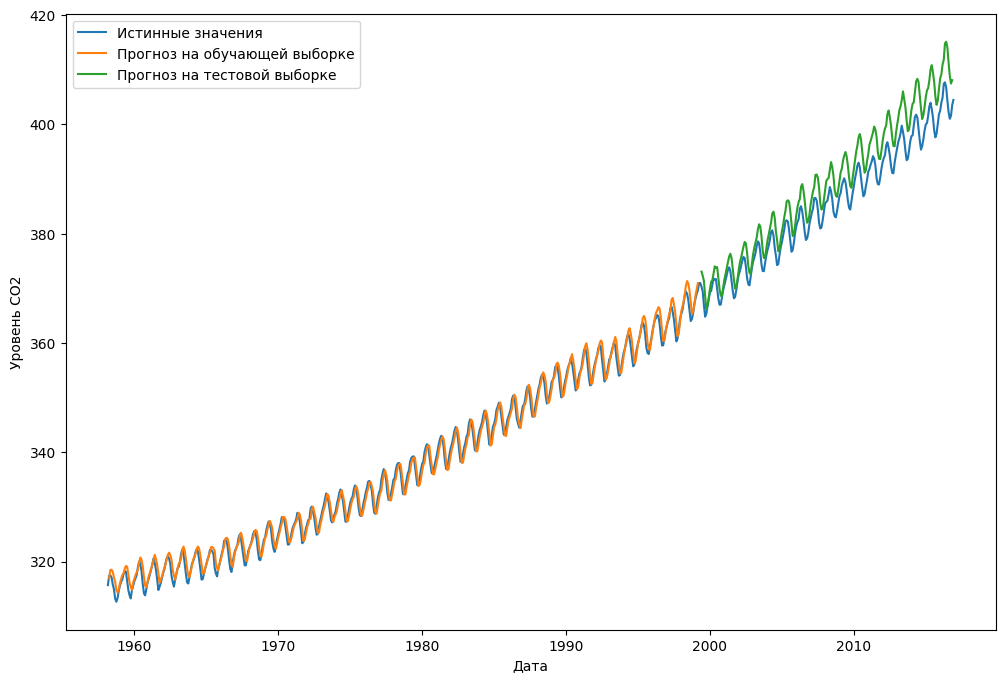

In [29]:
# Построение графика
look_back = 1

plt.figure(figsize=(12, 8))
plt.plot(data.index, data['interpolated'], label='Истинные значения')

# Построение графика для прогнозов на обучающей выборке
train_predict_plot = np.empty_like(data['interpolated'])
train_predict_plot[:] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back] = train_predict[:, 0]

# Построение графика для прогнозов на тестовой выборке
test_predict_plot = np.empty_like(data['interpolated'])
test_predict_plot[:] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(data)-1] = test_predict[:, 0]

plt.plot(data.index, train_predict_plot, label='Прогноз на обучающей выборке')
plt.plot(data.index, test_predict_plot, label='Прогноз на тестовой выборке')

plt.xlabel('Дата')
plt.ylabel('Уровень CO2')
plt.legend()
plt.show()